#### This ipynb checks the extracted features, boxes, and attributes.

In [28]:
import json
import numpy as np
import os
import os.path as osp
import sys
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 10)
from pprint import pprint
import time
import collections
import operator
from tqdm import tqdm

In [29]:
import sys
sys.path.insert(0, '..')

In [30]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 10)

# import some common detetron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures.instances import Instances

In [31]:
val2017_dir = "../datasets/coco/val2017"
image_name = "000000581781.jpg"
# image_name = "000000581615.jpg"
im = cv2.imread(osp.join(val2017_dir, image_name))
# plt.axis('off'); plt.imshow(im[:,:,::-1])

In [35]:
cfg = get_cfg()
cfg.merge_from_file("../configs/GENOME-Detection/faster_rcnn_attr_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
cfg.MODEL.WEIGHTS = "../output/genome_faster_rcnn_softmax0.5_expminus_attr_R_101_FPN_3x/model_final.pth"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

WARNING [01/07 07:04:35 d2.config.compat]: Config '../configs/GENOME-Detection/faster_rcnn_attr_R_101_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


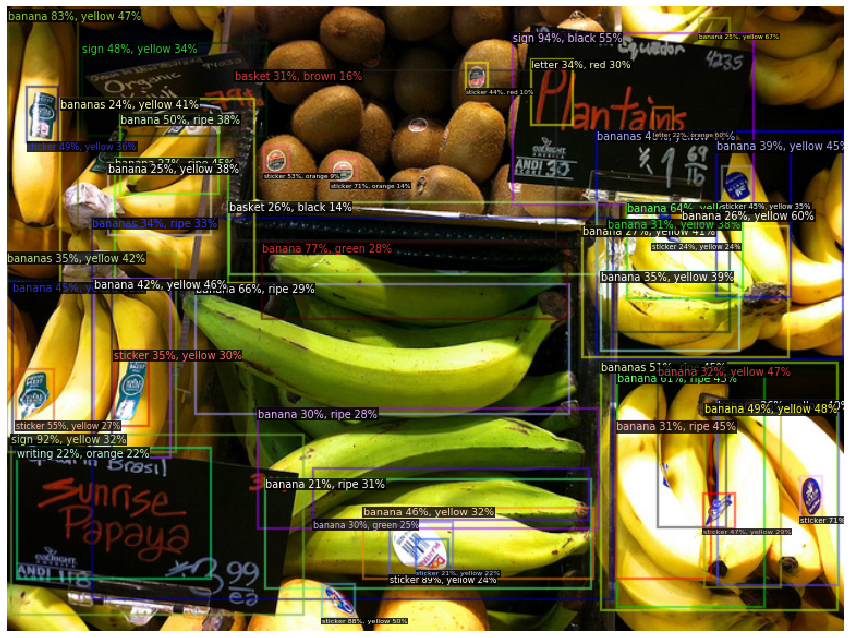

In [36]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.rcParams['figure.figsize'] = (15, 20)
plt.axis('off'); plt.imshow(v.get_image())

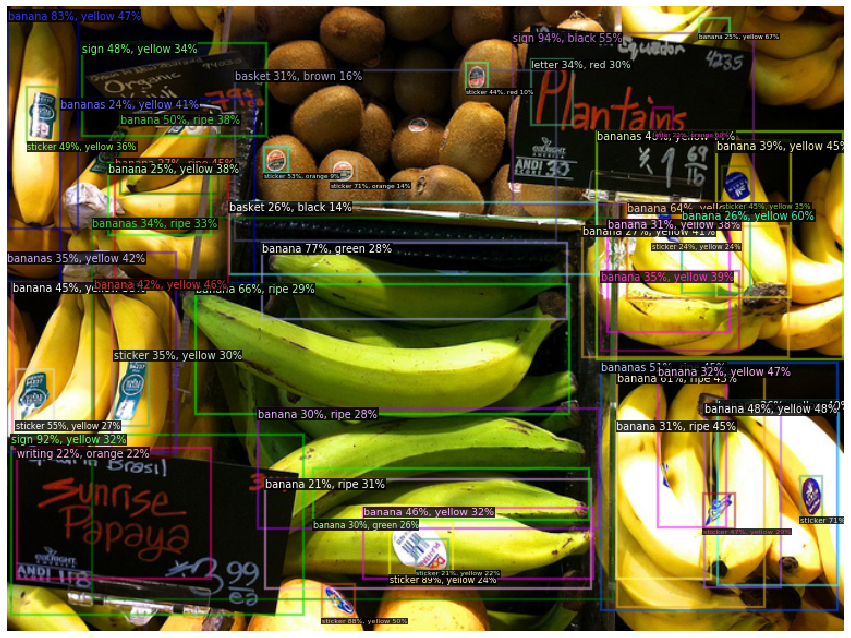

In [47]:
# load detected results
detections_dir = '../output/extracted_features/features'
det = np.load(osp.join(detections_dir, image_name.split('.')[0]+'.npz'))
instances = Instances(im.shape[:2])
# instances.pred_boxes = det['pred_boxes']
instances.pred_boxes = det['norm_bb']
instances.pred_boxes[:,0::2] = instances.pred_boxes[:,0::2] * instances.image_size[1]
instances.pred_boxes[:,1::2] = instances.pred_boxes[:,1::2] * instances.image_size[0]
instances.pred_classes, instances.scores = det['pred_probs'][:, :-1].argmax(1), det['pred_probs'][:, :-1].max(1)
instances.pred_attr_probs = torch.Tensor(det['pred_attr_probs'])
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(instances)
plt.rcParams['figure.figsize'] = (15, 20)
plt.axis('off'); plt.imshow(v.get_image())

In [48]:
# the detected boxes should be exactly same
print(outputs["instances"].to("cpu").pred_boxes.tensor.numpy().shape)
print(instances.pred_boxes.shape)
print(outputs["instances"].to("cpu").pred_boxes.tensor.numpy().sum())
print(instances.pred_boxes.sum())
# the scores are different due to nms not running on detect_and_extract_features()
print(outputs["instances"].to("cpu").scores.numpy().sum())
print(instances.scores.sum())

(50, 4)
(50, 4)
57906.31
57906.008
22.336008
22.338354


In [49]:
(det['norm_bb'][:,0::2] * instances.image_size[1]).sum() + (det['norm_bb'][:,1::2] * instances.image_size[0]).sum()

57906.008

In [45]:
outputs["instances"].to("cpu").pred_boxes.tensor.numpy().sum(1)

array([1131.6622 , 1023.2298 , 1462.8372 , 1417.3833 ,  230.77795,
       1045.7963 , 1981.3363 ,  767.90515, 1099.8944 , 1412.6542 ,
       1786.824  ,  639.2668 ,  649.78906, 1824.1621 ,  477.66486,
        222.78166, 1874.9019 ,  385.5954 , 1862.4268 , 1542.4304 ,
        635.98816, 1391.6396 ,  827.9486 ,  746.24585, 1458.1174 ,
       1469.1821 ,  775.58887,  660.3368 , 1482.1123 ,  968.2973 ,
       1145.2672 , 1722.9376 , 1760.3188 ,  825.54553, 1425.313  ,
       1352.1951 , 1426.6597 ,  583.3331 , 1475.9941 , 1925.1027 ,
       1461.6788 ,  977.84814, 1115.1201 ,  531.37994, 1346.2589 ,
        515.2795 ,  939.50903, 1179.9329 , 1452.0802 , 1489.7767 ],
      dtype=float32)

In [46]:
instances.pred_boxes.sum(1)

array([1131.6619 , 1023.23645, 1462.8427 , 1417.3755 ,  230.77798,
       1045.7966 , 1981.3367 ,  767.90515, 1099.885  , 1412.6649 ,
       1786.8547 ,  639.2676 ,  649.78906, 1824.1548 ,  477.66476,
        222.7817 , 1874.9048 ,  385.5955 , 1862.4312 , 1542.4464 ,
        635.999  , 1391.6405 ,  827.9486 ,  746.24695, 1458.0994 ,
       1469.1927 ,  775.58966,  660.3165 , 1482.06   ,  968.2973 ,
       1145.1881 , 1722.902  , 1760.2703 ,  825.5451 , 1425.3092 ,
       1352.1929 , 1426.5992 , 1475.9736 ,  583.3325 , 1925.103  ,
       1461.6658 ,  977.85016, 1115.1206 ,  531.37994, 1346.2614 ,
        515.27856,  939.521  , 1179.9327 , 1452.0472 , 1489.7723 ],
      dtype=float32)